### Trabajo Final Master Ciencia de Datos y Business Analytics
## Reporte Laboratorio Seco - Modelo de Predicción PROPHET
Septiembre 23, 2023

## Introducción
El siguiente cuaderno de laboratorio es un registro de la aplicación de un modelo PROPHET con el objetivo de encontrar el pronóstico adecuado a la data de POS de Sportline Colombia.

## Lectura de Datos y Adecuación de las Variables
Para el entrenamiento de los datos, es importante leerlos del archivo de juegos de datos POS del datamart. En este caso en particular, se leen los datos extraidos para el TFM correspondientes a las ventas de Sportline America Colombia del 1 de enero del 2018 al 30 de julio del 2023.

In [1]:
# Importar y leer archivo como DF Pandas
# Los archivos se leen de los formatos por año ya limpios

import pandas as pd
csv_file_path = '/Users/ameilij/Documents/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_diario.csv'
encoding = 'latin1'
dfPOS = pd.read_csv(csv_file_path, encoding=encoding)

In [2]:
# Preparar el archivo para entrenamiento
dfPOS['FECHA'] = pd.to_datetime(dfPOS['FECHA'], format= '%Y-%m-%d')
data_train = dfPOS[dfPOS['CODIGO_MARCA'] == 456]

Antes de comenzar el entrenamiento, revisemos una vez más la topología de la data para asegurarnos que tiene el valor esperado.

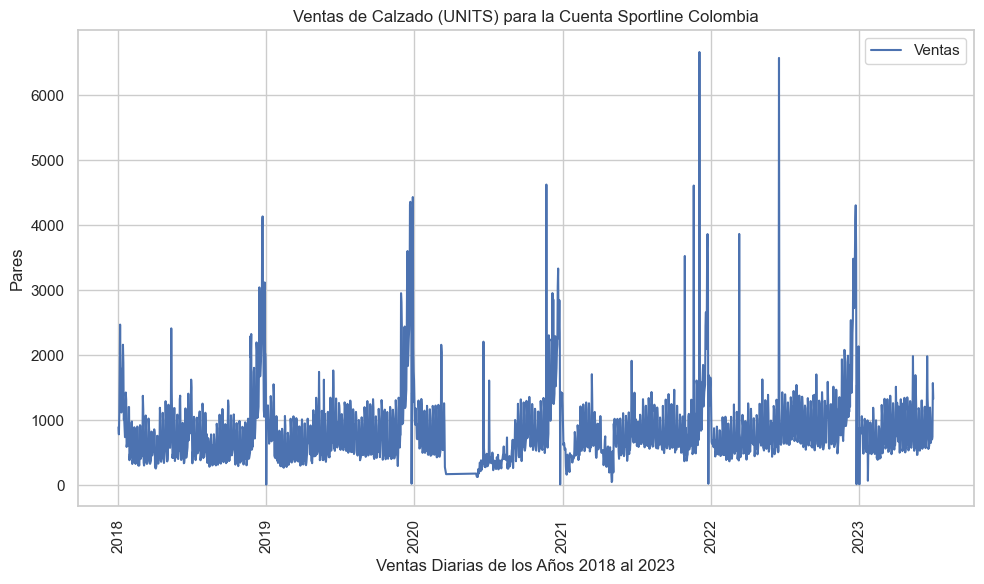

In [4]:
# Revisar la topologia de la serie de tiempos
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar la data por 'CODIGO_MARCA', y la semana del año
data_temp = data_train[['FECHA', 'CANTIDAD']].sort_values(by='FECHA', ascending=True)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='FECHA', y='CANTIDAD', data=data_temp, label='Ventas')
plt.title('Ventas de Calzado (UNITS) para la Cuenta Sportline Colombia')
plt.xlabel('Ventas Diarias de los Años 2018 al 2023')
plt.ylabel('Pares')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()  # Add a legend to label the line

plt.show()

## Entrenamiento de Datos
Para el entrenamiento de datos se utilizó la librería _Prophet_. _Prophet_ es un procedimiento para pronosticar datos de series temporales basado en un modelo aditivo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de las vacaciones. Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es resistente a los datos faltantes y a los cambios en la tendencia y, por lo general, maneja bien los valores atípicos.

/var/folders/9c/f5lf7vz91zs8mwbnjbtxzjgw0000gn/T/ipykernel_3485/2868023004.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.rename(columns={'FECHA': 'ds', 'CANTIDAD': 'y'}, inplace=True)
20:38:21 - cmdstanpy - INFO - Chain [1] start processing
20:38:21 - cmdstanpy - INFO - Chain [1] done processing


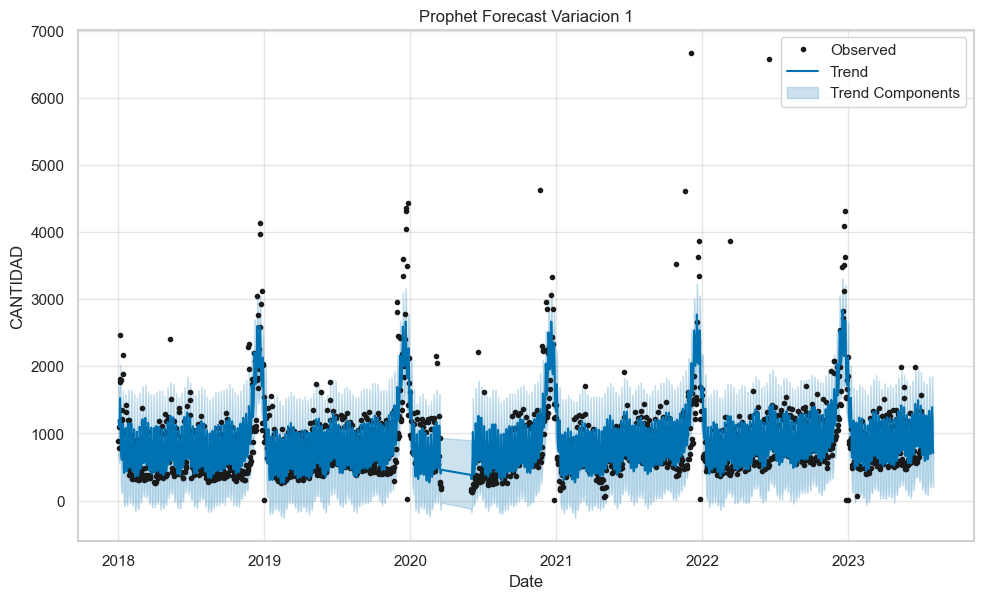

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

data_train.rename(columns={'FECHA': 'ds', 'CANTIDAD': 'y'}, inplace=True)
model = Prophet()
model.fit(data_train)

future = model.make_future_dataframe(periods=30)  # Adjust 'periods' as needed
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Prophet Forecast Variacion 1')
plt.xlabel('Date')
plt.ylabel('CANTIDAD')
plt.legend(["Observed", "Trend", "Trend Components", "Holidays", "Prediction"])
plt.show()

Prophet nos permite facilmente visualizar la tendencia, estacionalidad, y otros patrones de la serie de tiempo y su modelo.

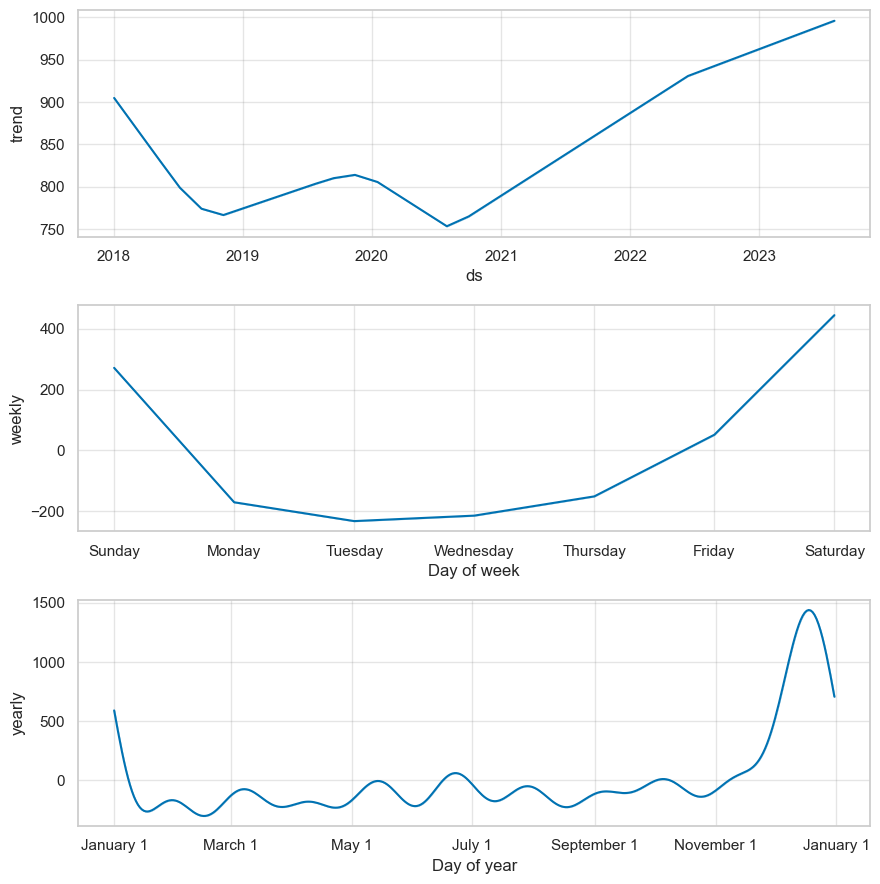

In [6]:
fig2 = model.plot_components(forecast)

Es interesante ver como la data evidencia dos caídas de ventas: a finales del 2018 y luego de nuevo en el 2020 debido a la pandemia. Las ventas levantan a comienzos de noviembre con un pico en diciembre, algo que vimos en la fase de EDA y razón por la que en muchos modelos creamos la variable `XMAS`.

In [7]:
# Calcular RMSE y R2 como en todos los otros análisis
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, r2_score

initial_window = "730 days"  # Adjust this value as needed
df_cv = cross_validation(model, initial=initial_window, period="90 days", horizon="365 days")
rmse = mean_squared_error(df_cv["y"], df_cv["yhat"]) ** 0.5
r2 = r2_score(df_cv["y"], df_cv["yhat"])

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

  0%|          | 0/11 [00:00<?, ?it/s]

20:41:06 - cmdstanpy - INFO - Chain [1] start processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
20:41:07 - cmdstanpy - INFO - Chain [1] start processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
20:41:07 - cmdstanpy - INFO - Chain [1] start processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
20:41:07 - cmdstanpy - INFO - Chain [1] start processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
20:41:07 - cmdstanpy - INFO - Chain [1] start processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
20:41:07 - cmdstanpy - INFO - Chain [1] start processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:08 - cmdstanpy - INFO - Chain [1] done processing
20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:08 - cmdstanpy - INFO - Chain [1] done processing
20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:08 - cmdstanpy - INFO - Chain [1]

RMSE: 521.41021228351
R2: 0.26497478763277094


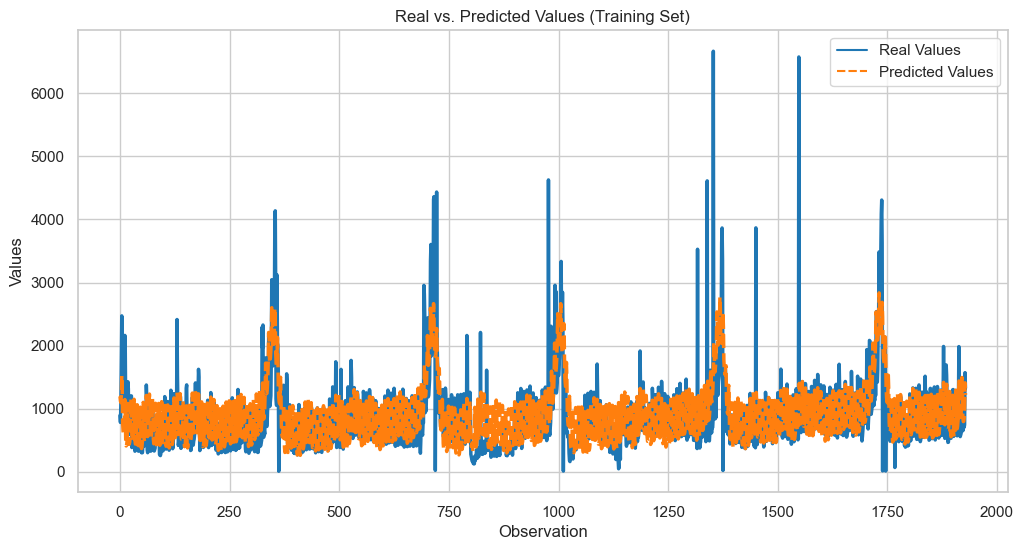

In [8]:
# Visualizar valores predecidos vs. realidad
y_real = data_train['y'].values
y_predicted = forecast.loc[:len(data_train) - 1, 'yhat'].values
comparison_df = pd.DataFrame({'Real Values': y_real, 'Predicted Values': y_predicted})

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, palette="tab10", linewidth=2.5)
plt.xlabel("Observation")
plt.ylabel("Values")
plt.title("Real vs. Predicted Values (Training Set)")
plt.show()

De todos los modelos, Prophet nos da el mejor valor de error cuadrático, reduciendo el error por órdenes de magnitud versus los modelos de regresión, ARIMA, y XGBoost. A pesar de que el coeficiente de determinación no es alto, el modelo tiene visualmente un gran poder de predicción. 

## Variacion 1: Data Semanal
Hemos visto en el laboratorio seco del modelo _XGBoost_ que el uso de data semanal mejoraba - y mucho - el poder predictivo del modelo. Es interesante poner la hipótesis a prueba con _Prophet_.

In [17]:
csv_file_path = '/Users/ameilij/Documents/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_semanal.csv'
encoding = 'latin1'
dfPOS_semanal = pd.read_csv(csv_file_path, encoding=encoding)
dfPOS_semanal['WEEK_OF_YEAR'] = pd.to_datetime(dfPOS_semanal['WEEK_OF_YEAR'] + '-0', format='%Y-%U-%w')
data_train = dfPOS_semanal[dfPOS_semanal['CODIGO_MARCA'] == 456]

In [20]:
data_train.head()

,CODIGO_MARCA,WEEK_OF_YEAR,CANTIDAD
0,456.0,2017-12-31,7008
1,456.0,2018-01-07,10634
2,456.0,2018-01-14,7706
3,456.0,2018-01-21,5586
4,456.0,2018-01-28,4387


20:56:31 - cmdstanpy - INFO - Chain [1] start processing
20:56:31 - cmdstanpy - INFO - Chain [1] done processing


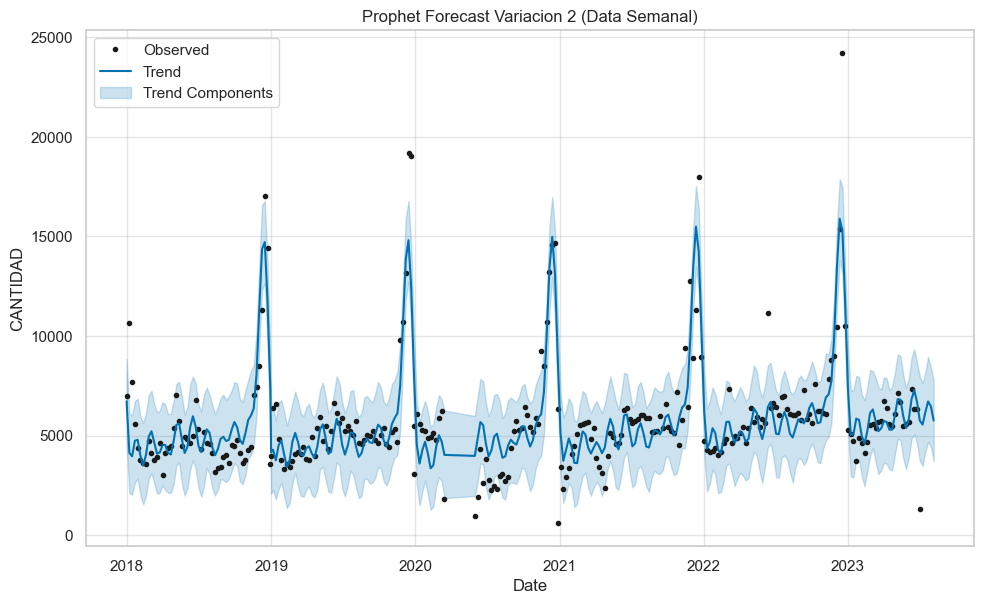

In [23]:
data_train.rename(columns={'WEEK_OF_YEAR': 'ds', 'CANTIDAD': 'y'}, inplace=True)
model_2 = Prophet()
model_2.fit(data_train)

future_2 = model_2.make_future_dataframe(periods=5, freq='W')  
forecast_2 = model_2.predict(future_2)

fig = model_2.plot(forecast_2)
plt.title('Prophet Forecast Variacion 2 (Data Semanal)')
plt.xlabel('Date')
plt.ylabel('CANTIDAD')
plt.legend(["Observed", "Trend", "Trend Components", "Holidays", "Prediction"])
plt.show()

In [22]:
warnings.filterwarnings('ignore')
initial_window = "730 days"  # Adjust this value as needed
df_cv_2 = cross_validation(model_2, initial=initial_window, period="90 days", horizon="365 days")
rmse = mean_squared_error(df_cv_2["y"], df_cv_2["yhat"]) ** 0.5
r2 = r2_score(df_cv_2["y"], df_cv_2["yhat"])

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

  0%|          | 0/11 [00:00<?, ?it/s]

20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:01 - cmdstanpy - INFO - Chain [1] done processing
20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:01 - cmdstanpy - INFO - Chain [1] done processing
20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:01 - cmdstanpy - INFO - Chain [1] done processing
20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:01 - cmdstanpy - INFO - Chain [1] done processing
20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:01 - cmdstanpy - INFO - Chain [1] done processing
20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:01 - cmdstanpy - INFO - Chain [1] done processing
20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:01 - cmdstanpy - INFO - Chain [1] done processing
20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:01 - cmdstanpy - INFO - Chain [1] done processing
20:56:02 - cmdstanpy - INFO - Chain [1] start processing
20:56:02 - cmdstanpy - INFO - Chain [1]

RMSE: 2054.7049525031593
R2: 0.49019618113898333


Los resultados son prometedores aunque no perfectos. Hemos mejorado mucho el coeficiente de determinación, pero hemos aumentado el error medio cuadrático. Por el momento seguiremos adelante con la data diaria.

## Variación 2: Declaración de Fechas Claves
Una funcionalidad clave de Prophet es la declaración de fechas importantes en el calendario para que el modelo pueda optimizar la predicción. Las fechas claves suelen tener efectos de _outlier_ que impactan la interpretación de los datos, y tener las fechas claves declaradas en el código del entrenamiento debiera mejorar el poder de predicción del mismo. En nuestro caso en particular las fechas claves son las temporadas altas de compras a fin de año (comenzando en el 1 de noviembre de cada año y terminan el 31 de diciembre del mismo) y el efecto negativo que tuvo en las ventas el COVID (en el caso particular de Colombia comenzando el 1 de marzo del 2020 y terminando el 30 de agosto del 2020 cuando la mayoría de las tiendas estaban operando casi normalmente).

In [24]:
# Crear la lista de fechas clave
custom_holidays = pd.DataFrame({
    'holiday': ['Xmas2018','Xmas2019', 'Xmas2020', 'COVID','Xmas2021','Xmas2022','Xmas2023'],
    'ds': pd.to_datetime(['2018-12-01','2019-12-01', '2020-12-01', '2020-03-01','2021-12-01','2022-12-01','2023-12-01']),
    'lower_window': 0,
    'upper_window': 30,
})

# Cargar datos diarios
csv_file_path = '/Users/ameilij/Documents/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_diario.csv'
encoding = 'latin1'
dfPOS = pd.read_csv(csv_file_path, encoding=encoding)
dfPOS['FECHA'] = pd.to_datetime(dfPOS['FECHA'], format= '%Y-%m-%d')
data_train = dfPOS[dfPOS['CODIGO_MARCA'] == 456]
data_train.rename(columns={'FECHA': 'ds', 'CANTIDAD': 'y'}, inplace=True)

20:58:19 - cmdstanpy - INFO - Chain [1] start processing
20:58:19 - cmdstanpy - INFO - Chain [1] done processing


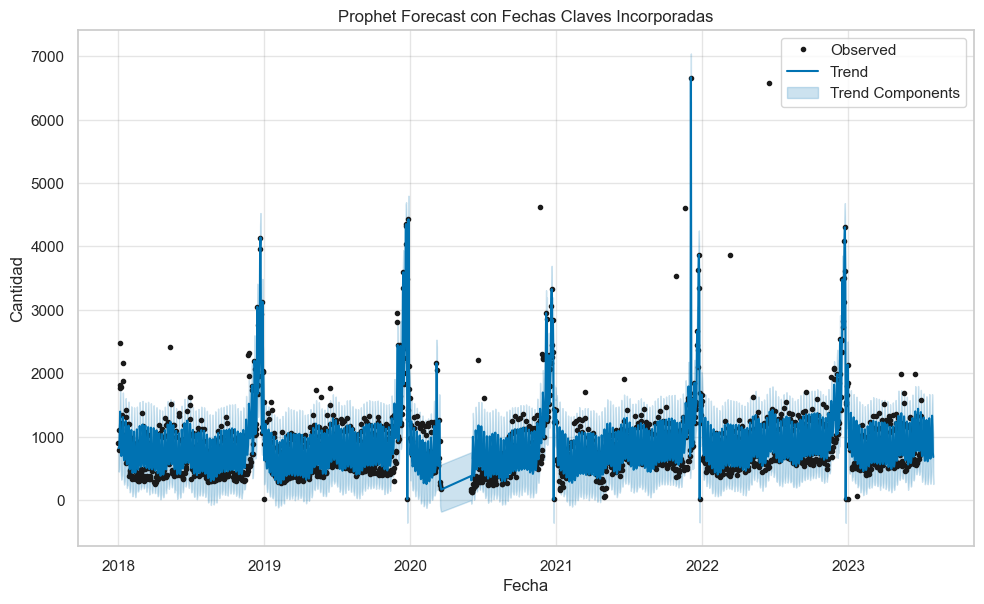

In [25]:
model_3 = Prophet(holidays=custom_holidays)
model_3.fit(data_train)

future_3 = model_3.make_future_dataframe(periods=30)  # Adjust 'periods' as needed
forecast_3 = model_3.predict(future_3)

fig = model_3.plot(forecast_3)
plt.title('Prophet Forecast con Fechas Claves Incorporadas')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend(["Observed", "Trend", "Trend Components", "Holidays", "Prediction"])
plt.show()

In [26]:
# Revisar resultados
initial_window = "730 days"  # Adjust this value as needed
df_cv_3 = cross_validation(model_3, initial=initial_window, period="90 days", horizon="365 days")
rmse = mean_squared_error(df_cv_3["y"], df_cv_3["yhat"]) ** 0.5
r2 = r2_score(df_cv_3["y"], df_cv_3["yhat"])

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

  0%|          | 0/11 [00:00<?, ?it/s]

20:58:28 - cmdstanpy - INFO - Chain [1] start processing
20:58:28 - cmdstanpy - INFO - Chain [1] done processing
20:58:28 - cmdstanpy - INFO - Chain [1] start processing
20:58:28 - cmdstanpy - INFO - Chain [1] done processing
20:58:29 - cmdstanpy - INFO - Chain [1] start processing
20:58:29 - cmdstanpy - INFO - Chain [1] done processing
20:58:29 - cmdstanpy - INFO - Chain [1] start processing
20:58:29 - cmdstanpy - INFO - Chain [1] done processing
20:58:30 - cmdstanpy - INFO - Chain [1] start processing
20:58:30 - cmdstanpy - INFO - Chain [1] done processing
20:58:30 - cmdstanpy - INFO - Chain [1] start processing
20:58:30 - cmdstanpy - INFO - Chain [1] done processing
20:58:31 - cmdstanpy - INFO - Chain [1] start processing
20:58:31 - cmdstanpy - INFO - Chain [1] done processing
20:58:31 - cmdstanpy - INFO - Chain [1] start processing
20:58:32 - cmdstanpy - INFO - Chain [1] done processing
20:58:32 - cmdstanpy - INFO - Chain [1] start processing
20:58:32 - cmdstanpy - INFO - Chain [1]

RMSE: 555.8110030544374
R2: 0.16478660606401396


El haber especificado las fechas claves de temporada alta y la pandemia no parece haber agregado nada de información al modelo que el modelo mismo no haya interpretado sin problemas. 

## Variación 3: Agregando Regresores al Modelo Prophet
La librería Prophet permite agregar regresores de manera muy sencilla al modelo. La hipótesis de la tercera variación es que agregar regresores para las fechas de temporada alta (columna `XMAS`) y la época de pandemia (la columna `COVID`) nos permite tener un modelo optimizado.

In [27]:
# Leer datos del archivo y crear regresores
csv_file_path = '/Users/ameilij/Documents/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_diario.csv'
encoding = 'latin1'
dfPOS = pd.read_csv(csv_file_path, encoding=encoding)
dfPOS['FECHA'] = pd.to_datetime(dfPOS['FECHA'], format= '%Y-%m-%d')

start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2020-08-01')
dfPOS['COVID19'] = dfPOS['FECHA'].apply(lambda date: 1 if pd.to_datetime('2020-03-01') <= date < pd.to_datetime('2020-08-01') else 0)

data_train = dfPOS[dfPOS['CODIGO_MARCA'] == 456]
data_train.rename(columns={'FECHA': 'ds', 'CANTIDAD': 'y'}, inplace=True)


In [28]:
model_4 = Prophet(holidays=custom_holidays)
model_4.add_regressor('COVID19')
model_4.add_regressor('XMAS')
model_4.fit(data_train)

21:02:12 - cmdstanpy - INFO - Chain [1] start processing
21:02:12 - cmdstanpy - INFO - Chain [1] done processing


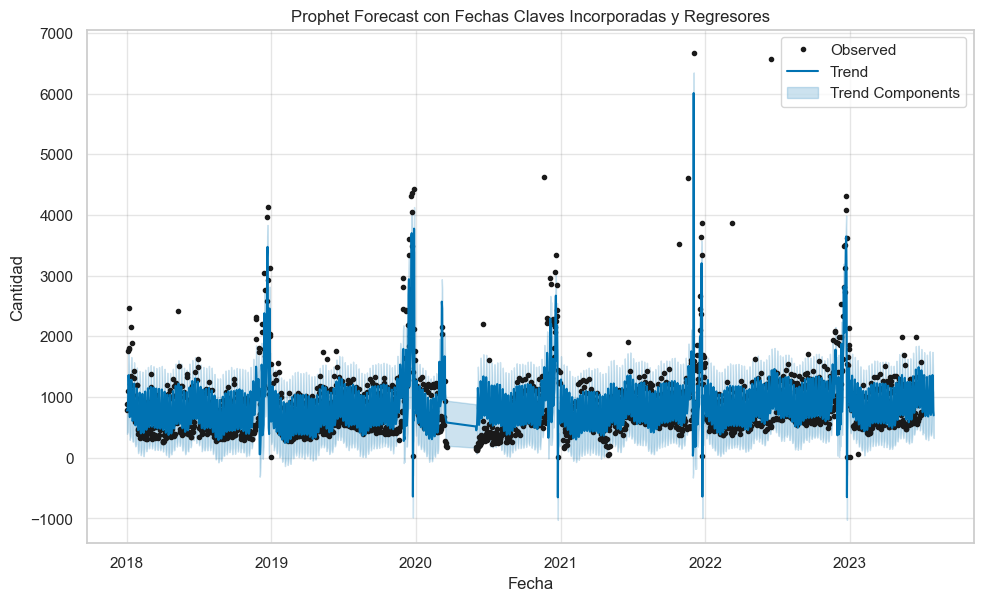

In [29]:
future = model_4.make_future_dataframe(periods=30)
future['COVID19'] = 0
future['XMAS'] = 0
forecast = model_4.predict(future)

fig = model_4.plot(forecast)
plt.title('Prophet Forecast con Fechas Claves Incorporadas y Regresores')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend(["Observed", "Trend", "Trend Components", "Holidays", "Prediction"])
plt.show()

In [30]:
# Revisar resultados
initial_window = "730 days"  # Adjust this value as needed
df_cv_4 = cross_validation(model_4, initial=initial_window, period="90 days", horizon="365 days")
rmse = mean_squared_error(df_cv_4["y"], df_cv_4["yhat"]) ** 0.5
r2 = r2_score(df_cv_4["y"], df_cv_4["yhat"])

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

  0%|          | 0/11 [00:00<?, ?it/s]

21:02:20 - cmdstanpy - INFO - Chain [1] start processing
21:02:21 - cmdstanpy - INFO - Chain [1] done processing
21:02:21 - cmdstanpy - INFO - Chain [1] start processing
21:02:21 - cmdstanpy - INFO - Chain [1] done processing
21:02:21 - cmdstanpy - INFO - Chain [1] start processing
21:02:21 - cmdstanpy - INFO - Chain [1] done processing
21:02:22 - cmdstanpy - INFO - Chain [1] start processing
21:02:22 - cmdstanpy - INFO - Chain [1] done processing
21:02:22 - cmdstanpy - INFO - Chain [1] start processing
21:02:22 - cmdstanpy - INFO - Chain [1] done processing
21:02:23 - cmdstanpy - INFO - Chain [1] start processing
21:02:23 - cmdstanpy - INFO - Chain [1] done processing
21:02:23 - cmdstanpy - INFO - Chain [1] start processing
21:02:23 - cmdstanpy - INFO - Chain [1] done processing
21:02:23 - cmdstanpy - INFO - Chain [1] start processing
21:02:24 - cmdstanpy - INFO - Chain [1] done processing
21:02:24 - cmdstanpy - INFO - Chain [1] start processing
21:02:24 - cmdstanpy - INFO - Chain [1]

RMSE: 490.6296042835791
R2: 0.34919531637383905


El agregar regresores nos permite reducir aún más el error cuadrático medio del modelo, con un resultado prometedor. Revisamos la precisión del modelo con una gráfica de valores reales versus valores de predicción. 

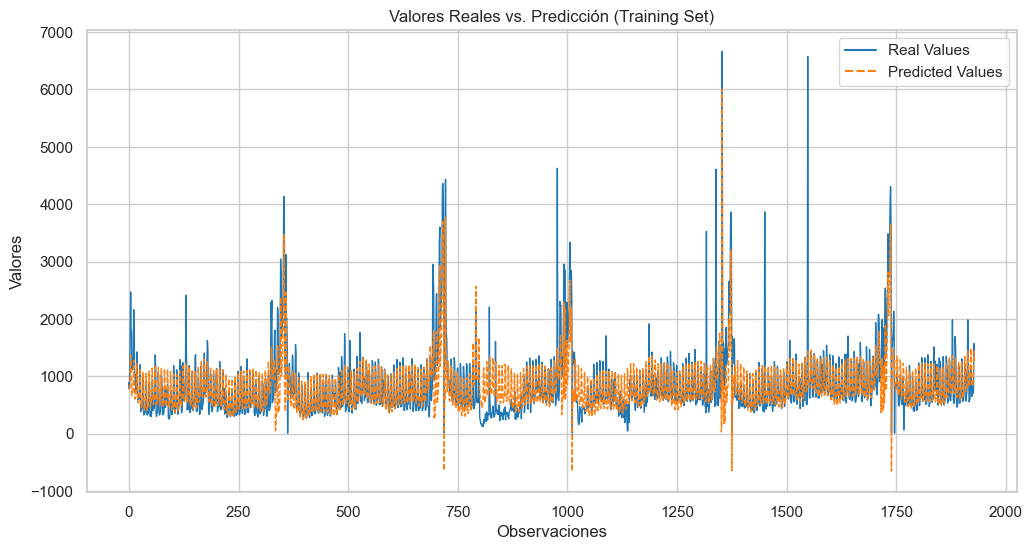

In [35]:
# Visualizar valores predecidos vs. realidad
y_real = data_train['y'].values
y_predicted = forecast.loc[:len(data_train) - 1, 'yhat'].values
comparison_df = pd.DataFrame({'Real Values': y_real, 'Predicted Values': y_predicted})

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, palette="tab10", linewidth=1)
plt.xlabel("Observaciones")
plt.ylabel("Valores")
plt.title("Valores Reales vs. Predicción (Training Set)")
plt.show()

El modelo de _Prophet_ con regresores agregados parece ser el más preciso de todos los vistos hasta el momento. 

|                   |   RMSE     |     R2    |
|-------------------|:----------:|:---------:|
| Regresión Lineal  | 243568.12  |  0.18     |
| Polinomio 4 Grado | 181688.81  |  0.39     |
| Arima (5,1,2)     | 169561.47  |  0.53     |
| XGBoost (Semanal) | 1534443.86 |  0.74     |
| Prophet (Reg.Ag.) |     490.62 |  0.35     |


## Conclusiones
El modelo Prophet con regresores agregados superó por mucho todos los modelos anteriores. Si bien el coeficiente de determinación no es el más alto - menos cuando comparado con XGBoost - es notable la forma en la que Prophet reduce el error cuadrático, arrojando predicciones muy cercana a los valores reales. 

Prophet es el modelo que sugiere Go Cloud, la empresa encargada de desarrollar el nuevo sistema de predicción de pronósticos de Nike Panamá. Que el trabajo de laboratorio corrobore la selección no es coincidencia, muchas empresas utilizan Prophet por sus cualidades de extraer modelos robustos a pesar de valores extremos y estacionalidades marcadas. Lo importante es que contar con un modelo paralelo que no es caja negra, sino sobre el cual se puede basar futuros desarrollos para optimizar el poder de predicción y planificación de la organización.